### In this nb we improve on the shock variable used in Exploratory1 and compare WTI response with SPX

In [1]:
import pandas as pd

In [2]:
wti = pd.read_csv('data/WTI.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()

<AxesSubplot:xlabel='date'>

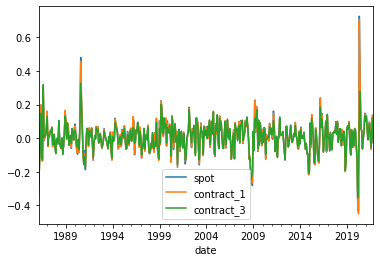

In [3]:
wti_pct = wti.pct_change().dropna()
wti_pct.plot()

In [4]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='date'>

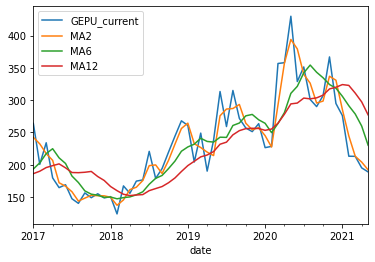

In [5]:
epu = pd.read_csv('data/EPUGlobal.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
epu['MA2'] = epu.GEPU_current.rolling(2).mean()
epu['MA6'] = epu.GEPU_current.rolling(6).mean()
epu['MA12'] = epu.GEPU_current.rolling(12).mean()
epu['MAD2'] = (epu.GEPU_current - epu.MA2).diff()
epu['MAD6'] = (epu.GEPU_current - epu.MA6).diff()
epu['MAD12'] = (epu.GEPU_current - epu.MA12).diff()
epu[['GEPU_current', 'MA2', 'MA6', 'MA12']]['2017-01-01':].plot()

In [6]:
epu.tail()

,GEPU_current,GEPU_ppp,MA2,MA6,MA12,MAD2,MAD6,MAD12
date,,,,,,,,
2021-01-01,276.110681,288.872662,285.485420,306.011544,324.136388,26.690392,-6.193359,-22.888182
2021-02-01,213.135741,222.659348,244.623211,291.356148,322.866002,-22.112731,-48.319545,-61.704554
2021-03-01,212.966679,222.147678,213.051210,278.509712,310.876638,31.402939,12.677375,11.820303
2021-04-01,195.100508,206.676606,204.033594,259.860698,297.298019,-8.848555,0.782841,-4.287553
2021-05-01,188.815918,198.143322,191.958213,230.164948,277.197867,5.790791,23.411161,13.815562


<AxesSubplot:xlabel='date'>

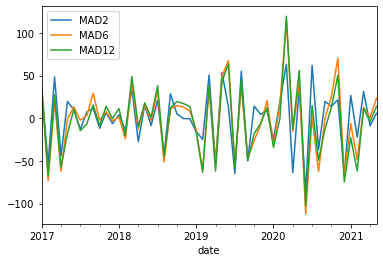

In [7]:
epu[['MAD2', 'MAD6', 'MAD12']].loc['2017-01-01':].plot()

<AxesSubplot:xlabel='date'>

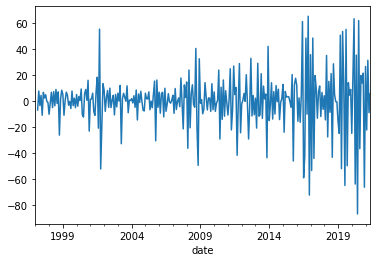

In [8]:
epu.MAD2.plot()

<AxesSubplot:xlabel='date'>

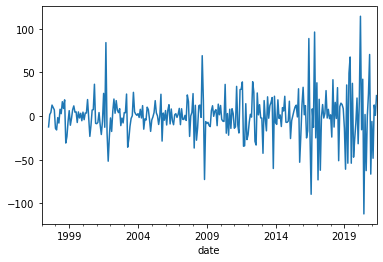

In [9]:
epu.MAD6.plot()

<AxesSubplot:xlabel='date'>

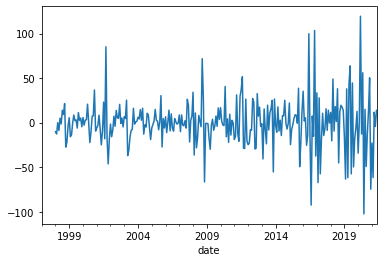

In [10]:
epu.MAD12.plot()

MA12 looks to be the best signal for surprises, hence MAD12 is probably the best signal. This is verified on the historical plot.

In [11]:
epu.dropna().head()

,GEPU_current,GEPU_ppp,MA2,MA6,MA12,MAD2,MAD6,MAD12
date,,,,,,,,
1998-01-01,97.823585,94.360973,102.034976,84.966553,78.770782,-10.052734,-14.029271,-10.205067
1998-02-01,85.675712,83.320993,91.749648,88.714002,79.312917,-1.862545,-15.895321,-12.690008
1998-03-01,87.248872,82.809098,86.462292,92.073767,80.877599,6.860516,-1.786606,0.008477
1998-04-01,78.904417,72.911993,83.076644,91.743772,81.336071,-4.958807,-8.014461,-8.802926
1998-05-01,85.100300,79.190424,82.002359,90.166542,82.464346,7.270169,7.773114,5.067608


In [12]:
df = wti_pct.join(epu[['MAD2', 'MAD6', 'MAD12']]).dropna()
df.head()

,spot,contract_1,contract_3,MAD2,MAD6,MAD12
date,,,,,,
1998-01-01,-0.087834,-0.086790,-0.083957,-10.052734,-14.029271,-10.205067
1998-02-01,-0.039474,-0.038852,-0.030940,-1.862545,-15.895321,-12.690008
1998-03-01,-0.058531,-0.064677,-0.054217,6.860516,-1.786606,0.008477
1998-04-01,0.015212,0.027926,0.032484,-4.958807,-8.014461,-8.802926
1998-05-01,-0.028664,-0.034282,-0.004935,7.270169,7.773114,5.067608


In [13]:
import statsmodels.api as sm

In [14]:
def news_regression(y_col, x_col, lags=12, df=df):
    x_cols = []
    for i in range(lags+1):
        new_col = f'{x_col}-lag{i}'
        df[new_col] = df[f'{x_col}'].shift(i)
        x_cols.append(new_col)
    df = df.dropna()
    return sm.OLS(df[y_col], sm.add_constant(df[x_cols])).fit()

In [15]:
model1 = news_regression('spot', 'MAD12')
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.093
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.366
Time:                        23:14:35   Log-Likelihood:                 237.53
No. Observations:                 269   AIC:                            -447.1
Df Residuals:                     255   BIC:                            -396.7
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0113      0.007      1.736      0.084      -0.002       0.024
MAD12-lag0     -0.0008      0.000     -1.862      0.064      -0.002    4.41e-05
MAD12-lag1     -0.0007      0.000     -1.795      0.074      -0.001     6.7e-05
MAD12-lag2  -6.769e-05      0.001     -0.112      0.911      -0.001       0.001
MAD12-lag3      0.0001      0.000      0.316      0.752      -0.001       0.001
MAD12-lag4     -0.0003      0.000     -1.227      0.221      -0.001       0.000
MAD12-lag5     -0.0003      0.000     -1.033      0.303      -0.001       0.000
MAD12-lag6   8.028e-05      0.000      0.301      0.764      -0.000       0.001
MAD12-lag7     -0.0003      0.000     -1.164      0.246      -0.001       0.000
MAD12-lag8   -8.95e-05      0.000     -0.351      0.726      -0.001       0.000
MAD12-lag9   8.221e-05      0.000      0.240      0.811      -0.001       0.001
MAD12-lag10    -0.0003      0.000     -1.111      0.268      -0.001       0.000
MAD12-lag11    -0.0001      0.000     -0.313      0.754      -0.001       0.001
MAD12-lag12     0.0003      0.000      0.778      0.437      -0.000       0.001
==============================================================================
Omnibus:                       81.867   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1134.165
Skew:                           0.772   Prob(JB):                    5.24e-247
Kurtosis:                      12.940   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [16]:
model2 = news_regression('contract_1', 'MAD12')

In [17]:
model3 = news_regression('contract_3', 'MAD12')

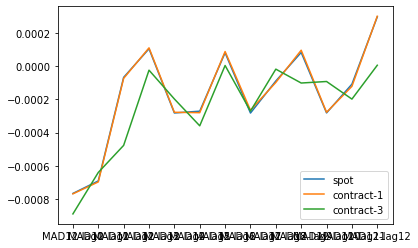

In [18]:
plt.plot(model1.params[1:], label='spot')
plt.plot(model2.params[1:], label='contract-1')
plt.plot(model3.params[1:], label='contract-3')
plt.legend()

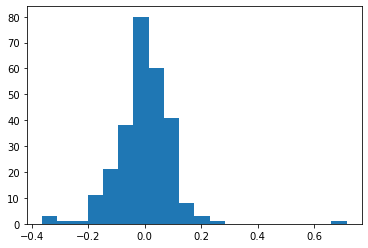

In [19]:
plt.hist(model1.resid, bins=20)
plt.show()

We can see that using MA as benchmark for expectations rather than linearly exptraolating last month's data (as in Exploratory1) is a more unbiased estimator of shock value. However, fat tails remain due to increased variance in shocks in recent years.

<AxesSubplot:xlabel='date'>

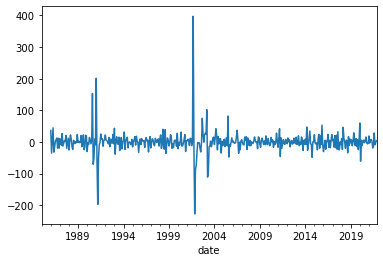

In [20]:
gpr = pd.read_csv('data/GPRGlobal.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
gpr['MA12'] = gpr.GPRI.rolling(12).mean()
gpr['MAD12'] = (gpr.GPRI - gpr.MA12).diff()
gpr['MAD12'].plot()

In [21]:
df2 = wti_pct.join(gpr['MAD12'])

In [22]:
model4 = news_regression('spot', 'MAD12', df=df2)
model4.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.8678
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.588
Time:                        23:14:36   Log-Likelihood:                 394.38
No. Observations:                 418   AIC:                            -760.8
Df Residuals:                     404   BIC:                            -704.3
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0080      0.005      1.709      0.088      -0.001       0.017
MAD12-lag0    6.51e-05      0.000      0.294      0.769      -0.000       0.001
MAD12-lag1     -0.0002      0.000     -1.048      0.295      -0.001       0.000
MAD12-lag2     -0.0002      0.000     -1.174      0.241      -0.001       0.000
MAD12-lag3     -0.0003      0.000     -1.745      0.082      -0.001    3.96e-05
MAD12-lag4     -0.0001      0.000     -0.693      0.489      -0.000       0.000
MAD12-lag5     -0.0001      0.000     -0.956      0.340      -0.000       0.000
MAD12-lag6     -0.0002      0.000     -1.004      0.316      -0.001       0.000
MAD12-lag7     -0.0002      0.000     -1.439      0.151      -0.000    6.46e-05
MAD12-lag8     -0.0001      0.000     -1.095      0.274      -0.000       0.000
MAD12-lag9   8.123e-05      0.000      0.470      0.639      -0.000       0.000
MAD12-lag10    -0.0002      0.000     -1.307      0.192      -0.000    8.84e-05
MAD12-lag11  1.458e-05      0.000      0.137      0.891      -0.000       0.000
MAD12-lag12 -8.981e-05      0.000     -0.710      0.478      -0.000       0.000
==============================================================================
Omnibus:                      117.316   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1768.500
Skew:                           0.741   Prob(JB):                         0.00
Kurtosis:                      12.967   Cond. No.                         43.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
model5 = news_regression('contract_1', 'MAD12', df=df2)
model6 = news_regression('contract_3', 'MAD12', df=df2)

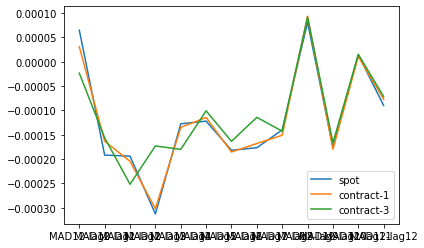

In [24]:
plt.plot(model4.params[1:], label='spot')
plt.plot(model5.params[1:], label='contract-1')
plt.plot(model6.params[1:], label='contract-3')
plt.legend()

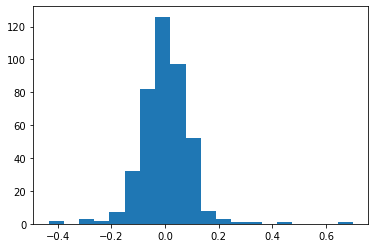

In [25]:
plt.hist(model4.resid, bins=20)
plt.show()

To account for US interventions in the Middle East at the turn of the millenium, we can split the data into pre-2005 and post-2005 to see if that changes our GPRI regression.

In [26]:
model7 = news_regression('spot', 'MAD12', df=df2.loc[:'2005-01-01'])
model7.get_robustcov_results().summary()

<ipython-input-14-db4d7de90bb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[f'{x_col}'].shift(i)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                     1.010
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.443
Time:                        23:14:36   Log-Likelihood:                 244.88
No. Observations:                 216   AIC:                            -461.8
Df Residuals:                     202   BIC:                            -414.5
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0073      0.005      1.330      0.185      -0.004       0.018
MAD12-lag0   8.961e-05      0.000      0.340      0.734      -0.000       0.001
MAD12-lag1     -0.0002      0.000     -1.072      0.285      -0.001       0.000
MAD12-lag2     -0.0002      0.000     -1.359      0.176      -0.001    9.34e-05
MAD12-lag3     -0.0001      0.000     -1.020      0.309      -0.000       0.000
MAD12-lag4     -0.0002      0.000     -1.146      0.253      -0.001       0.000
MAD12-lag5  -7.128e-05      0.000     -0.542      0.588      -0.000       0.000
MAD12-lag6     -0.0001      0.000     -0.682      0.496      -0.001       0.000
MAD12-lag7     -0.0001      0.000     -1.030      0.304      -0.000       0.000
MAD12-lag8  -4.877e-05      0.000     -0.347      0.729      -0.000       0.000
MAD12-lag9    2.13e-05      0.000      0.132      0.895      -0.000       0.000
MAD12-lag10 -7.272e-05      0.000     -0.515      0.607      -0.000       0.000
MAD12-lag11 -4.034e-05      0.000     -0.364      0.716      -0.000       0.000
MAD12-lag12 -9.767e-05      0.000     -0.720      0.472      -0.000       0.000
==============================================================================
Omnibus:                       62.856   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.603
Skew:                           1.097   Prob(JB):                     5.17e-56
Kurtosis:                       7.845   Cond. No.                         57.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [27]:
model8 = news_regression('spot', 'MAD12', df=df2.loc['2005-01-01':])
model8.get_robustcov_results().summary()

<ipython-input-14-db4d7de90bb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[f'{x_col}'].shift(i)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.024
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.430
Time:                        23:14:36   Log-Likelihood:                 155.72
No. Observations:                 191   AIC:                            -283.4
Df Residuals:                     177   BIC:                            -237.9
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0089      0.008      1.064      0.289      -0.008       0.025
MAD12-lag0     -0.0003      0.001     -0.585      0.560      -0.001       0.001
MAD12-lag1     -0.0005      0.001     -0.614      0.540      -0.002       0.001
MAD12-lag2     -0.0011      0.001     -1.211      0.228      -0.003       0.001
MAD12-lag3     -0.0020      0.001     -1.886      0.061      -0.004    9.28e-05
MAD12-lag4     -0.0005      0.001     -0.572      0.568      -0.002       0.001
MAD12-lag5     -0.0008      0.001     -1.237      0.218      -0.002       0.000
MAD12-lag6     -0.0012      0.001     -1.479      0.141      -0.003       0.000
MAD12-lag7     -0.0012      0.001     -1.973      0.050      -0.002    4.07e-07
MAD12-lag8     -0.0011      0.001     -1.745      0.083      -0.002       0.000
MAD12-lag9     -0.0003      0.001     -0.460      0.646      -0.002       0.001
MAD12-lag10    -0.0008      0.001     -1.094      0.275      -0.002       0.001
MAD12-lag11    -0.0003      0.001     -0.437      0.663      -0.001       0.001
MAD12-lag12    -0.0002      0.000     -0.358      0.721      -0.001       0.001
==============================================================================
Omnibus:                       34.273   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.608
Skew:                           0.108   Prob(JB):                     9.70e-68
Kurtosis:                       9.223   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

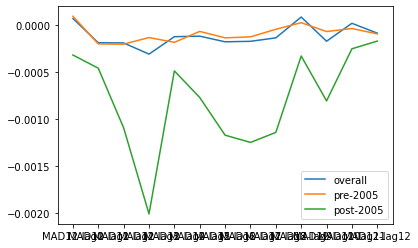

In [28]:
plt.plot(model4.params[1:], label='overall')
plt.plot(model7.params[1:], label='pre-2005')
plt.plot(model8.params[1:], label='post-2005')
plt.legend()

How does crude's reaction time compare to stocks? We will test this with EPU shocks.

In [29]:
spx = pd.read_csv('data/SP500.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
df3 = spx.pct_change().join(epu['MAD12']).dropna()
df3.head()

,SP500,MAD12
date,,
2012-02-01,0.040589,-23.308422
2012-03-01,0.031332,-8.132149
2012-04-01,-0.007497,-8.686615
2012-05-01,-0.062651,27.059171
2012-06-01,0.039555,22.755239


In [30]:
model9 = news_regression('SP500', 'MAD12', df=df3)
model9.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2.104
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0217
Time:                        23:14:37   Log-Likelihood:                 196.50
No. Observations:                 100   AIC:                            -365.0
Df Residuals:                      86   BIC:                            -328.5
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0112      0.004      2.973      0.004       0.004       0.019
MAD12-lag0     -0.0002      0.000     -1.096      0.276      -0.000       0.000
MAD12-lag1      0.0003      0.000      2.603      0.011    7.27e-05       0.001
MAD12-lag2   3.052e-05      0.000      0.262      0.794      -0.000       0.000
MAD12-lag3  -7.516e-05      0.000     -0.650      0.517      -0.000       0.000
MAD12-lag4   9.976e-05      0.000      0.781      0.437      -0.000       0.000
MAD12-lag5  -3.485e-05      0.000     -0.235      0.815      -0.000       0.000
MAD12-lag6     -0.0001      0.000     -0.724      0.471      -0.000       0.000
MAD12-lag7     -0.0002      0.000     -1.627      0.107      -0.001    5.01e-05
MAD12-lag8   6.198e-05      0.000      0.374      0.709      -0.000       0.000
MAD12-lag9     -0.0002      0.000     -1.301      0.197      -0.001       0.000
MAD12-lag10    -0.0001      0.000     -0.736      0.464      -0.000       0.000
MAD12-lag11     0.0002      0.000      1.468      0.146   -6.28e-05       0.000
MAD12-lag12     0.0001      0.000      1.049      0.297      -0.000       0.000
==============================================================================
Omnibus:                        4.518   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                3.857
Skew:                          -0.401   Prob(JB):                        0.145
Kurtosis:                       3.531   Cond. No.                         55.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

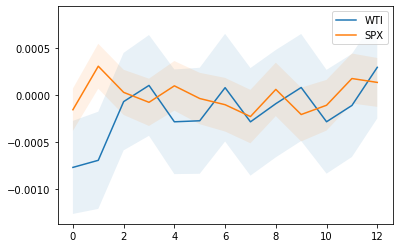

In [31]:
plt.plot(model1.params[1:].reset_index(drop=True), label='WTI')
plt.plot(model9.params[1:].reset_index(drop=True), label='SPX')
plt.fill_between([*range(13)], model1.conf_int()[0][1:], model1.conf_int()[1][1:], alpha=.1)
plt.fill_between([*range(13)], model9.conf_int()[0][1:], model9.conf_int()[1][1:], alpha=.1)
plt.legend()

How about if we now look at shocks in the VIX?

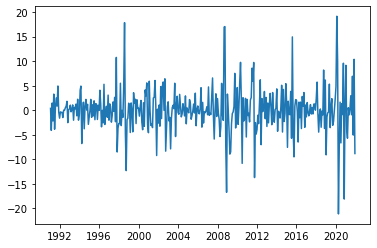

In [32]:
vix = pd.read_csv('data/VIX.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
vix['MA12'] = vix.VIX.rolling(12).mean()
vix['MAD12'] = (vix.VIX - vix.MA12).diff()
plt.plot(vix.MAD12)

In [33]:
df4 = spx.pct_change().join(vix['MAD12']).dropna()
df4.head()

,SP500,MAD12
date,,
2012-02-01,0.040589,-1.016668
2012-03-01,0.031332,-2.743333
2012-04-01,-0.007497,1.450000
2012-05-01,-0.062651,6.192499
2012-06-01,0.039555,-7.026666


In [34]:
model10 = news_regression('SP500', 'MAD12', df=df4)
model10.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     15.08
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           1.17e-17
Time:                        23:14:37   Log-Likelihood:                 260.61
No. Observations:                 107   AIC:                            -493.2
Df Residuals:                      93   BIC:                            -455.8
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0116      0.002      5.243      0.000       0.007       0.016
MAD12-lag0     -0.0064      0.001    -11.154      0.000      -0.008      -0.005
MAD12-lag1     -0.0020      0.001     -3.541      0.001      -0.003      -0.001
MAD12-lag2     -0.0010      0.001     -1.666      0.099      -0.002       0.000
MAD12-lag3     -0.0011      0.001     -2.199      0.030      -0.002      -0.000
MAD12-lag4     -0.0008      0.001     -1.343      0.183      -0.002       0.000
MAD12-lag5     -0.0006      0.001     -0.976      0.332      -0.002       0.001
MAD12-lag6     -0.0004      0.001     -0.540      0.591      -0.002       0.001
MAD12-lag7     -0.0009      0.001     -1.241      0.218      -0.002       0.001
MAD12-lag8     -0.0010      0.001     -1.612      0.110      -0.002       0.000
MAD12-lag9     -0.0009      0.000     -1.799      0.075      -0.002    9.13e-05
MAD12-lag10    -0.0004      0.000     -0.931      0.354      -0.001       0.000
MAD12-lag11    -0.0005      0.001     -1.025      0.308      -0.002       0.001
MAD12-lag12    -0.0007      0.000     -1.695      0.093      -0.002       0.000
==============================================================================
Omnibus:                        4.083   Durbin-Watson:                   2.386
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                4.594
Skew:                          -0.150   Prob(JB):                        0.101
Kurtosis:                       3.970   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [35]:
df5 = wti_pct.join(vix['MAD12']).dropna()
model11 = news_regression('spot', 'MAD12', df=df5)
model11.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     2.277
Date:                Thu, 30 Dec 2021   Prob (F-statistic):            0.00689
Time:                        23:14:37   Log-Likelihood:                 363.72
No. Observations:                 358   AIC:                            -699.4
Df Residuals:                     344   BIC:                            -645.1
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0085      0.005      1.782      0.076      -0.001       0.018
MAD12-lag0     -0.0028      0.001     -1.970      0.050      -0.006   -5.07e-06
MAD12-lag1     -0.0079      0.002     -3.732      0.000      -0.012      -0.004
MAD12-lag2     -0.0040      0.002     -1.899      0.058      -0.008       0.000
MAD12-lag3     -0.0024      0.002     -0.976      0.330      -0.007       0.002
MAD12-lag4     -0.0008      0.002     -0.492      0.623      -0.004       0.002
MAD12-lag5   5.339e-05      0.001      0.037      0.971      -0.003       0.003
MAD12-lag6     -0.0004      0.001     -0.332      0.740      -0.003       0.002
MAD12-lag7     -0.0004      0.001     -0.321      0.748      -0.003       0.002
MAD12-lag8     -0.0010      0.001     -0.941      0.347      -0.003       0.001
MAD12-lag9     -0.0005      0.001     -0.476      0.634      -0.003       0.002
MAD12-lag10    -0.0011      0.001     -1.022      0.307      -0.003       0.001
MAD12-lag11    -0.0009      0.001     -0.810      0.419      -0.003       0.001
MAD12-lag12     0.0009      0.001      0.747      0.455      -0.002       0.003
==============================================================================
Omnibus:                       78.616   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.988
Skew:                           0.636   Prob(JB):                    2.17e-143
Kurtosis:                       9.513   Cond. No.                         5.36
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

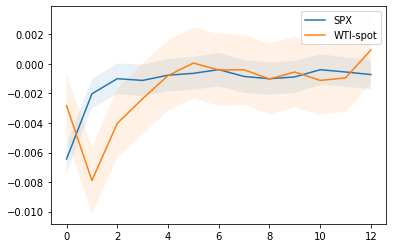

In [36]:
plt.plot(model10.params[1:].reset_index(drop=True), label='SPX')
plt.plot(model11.params[1:].reset_index(drop=True), label='WTI-spot')
plt.fill_between([*range(13)], model10.conf_int()[0][1:], model10.conf_int()[1][1:], alpha=.1)
plt.fill_between([*range(13)], model11.conf_int()[0][1:], model11.conf_int()[1][1:], alpha=.1)
plt.legend()

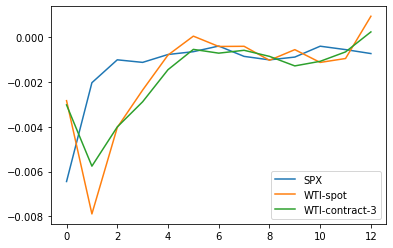

In [37]:
model12 = news_regression('contract_3', 'MAD12', df=df5)
plt.plot(model10.params[1:].reset_index(drop=True), label='SPX')
plt.plot(model11.params[1:].reset_index(drop=True), label='WTI-spot')
plt.plot(model12.params[1:].reset_index(drop=True), label='WTI-contract-3')
plt.legend()

Not surprising that WTI reacts slower than stocks to changes in the VIX.